In [2]:
%pip install pyaurn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import pyaurn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]
import os

from concurrent.futures import ThreadPoolExecutor, wait
#from google.colab import drive
from shutil import make_archive, move
from math import sin, cos
from IPython.display import clear_output


In [4]:
metadata = pyaurn.importMeta().set_index("site_id")

In [5]:
display(metadata)
filtered_metadata = metadata.drop(["site_name", "location_type", "parameter", "Parameter_name", "start_date", "end_date", "ratified_to", "zone", "agglomeration", "local_authority"], axis=1)

,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
site_id,,,,,,,,,,,,
ABD,Aberdeen,Urban Background,57.157360,-2.094278,O3,Ozone,2003-08-01,2021-09-20,2021-09-20,North East Scotland,NaN,Aberdeen City
ABD9,Aberdeen Erroll Park,Urban Background,57.157400,-2.094770,O3,Ozone,2021-10-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD7,Aberdeen Union Street Roadside,Urban Traffic,57.144555,-2.106472,NO,Nitric oxide,2008-01-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD8,Aberdeen Wellington Road,Urban Traffic,57.133888,-2.094198,NO,Nitric oxide,2016-02-09,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ARM6,Armagh Roadside,Urban Traffic,54.353728,-6.654558,NO,Nitric oxide,2009-01-01,ongoing,2022-09-30,Northern Ireland,NaN,Armagh
...,...,...,...,...,...,...,...,...,...,...,...,...
WRAY,Wray,Rural Background,54.104666,-2.584182,O3,Ozone,1985-04-01,1988-02-29,1988-02-29,North West & Merseyside,NaN,Lancaster
WREX,Wrexham,Urban Traffic,53.042282,-3.002829,NO,Nitric oxide,2002-03-06,ongoing,2022-09-30,North Wales,NaN,Wrexham
YW,Yarner Wood,Rural Background,50.597600,-3.716510,O3,Ozone,1987-06-26,ongoing,2022-09-30,South West,NaN,Teignbridge


In [6]:
def get_raw_data(name, year_range):
    data = pyaurn.importAURN(name, year_range).reset_index()
    data["site_id"] = name
    return data

In [15]:
def prepare_site_data(data):
  try:
    if "PM2.5" in data.columns:
      data.date = data.date.astype("datetime64[s]").astype("int64")
      data = data[["date", "PM2.5", "site_id"]]
      data = data.dropna()
      data = data.merge(filtered_metadata, on="site_id").drop("site_id", axis=1)
      return data
  except KeyError:
    return

In [8]:
display(metadata.index)
with ThreadPoolExecutor(min(32, os.cpu_count() + 4)) as executor:
  all_data = [executor.submit(get_raw_data, name, range(2020, 2022)) for name in metadata.index]
  all_data = wait(all_data)
  clear_output()

In [9]:
raw_data = [item.result() for item in all_data.done]
display(raw_data[0])

,date,NO,NO2,NOXasNO2,wd,ws,temp,site,code,site_id
0,2020-01-01 00:00:00,5.41376,15.17518,23.47616,122.5,2.7,4.3,Widnes Milton Road,WSMR,WSMR
1,2020-01-01 01:00:00,5.22707,19.78219,27.79692,141.9,2.8,3.8,Widnes Milton Road,WSMR,WSMR
2,2020-01-01 02:00:00,7.31557,17.89410,29.11115,158.5,3.4,3.6,Widnes Milton Road,WSMR,WSMR
3,2020-01-01 03:00:00,5.56543,18.84930,27.38285,177.7,2.5,3.5,Widnes Milton Road,WSMR,WSMR
4,2020-01-01 04:00:00,1.71513,17.46172,20.09156,177.8,3.2,3.7,Widnes Milton Road,WSMR,WSMR
...,...,...,...,...,...,...,...,...,...,...
17539,2021-12-31 19:00:00,170.24093,61.72998,322.76244,149.5,3.6,7.7,Widnes Milton Road,WSMR,WSMR
17540,2021-12-31 20:00:00,66.92990,52.13659,154.76101,159.5,5.1,8.9,Widnes Milton Road,WSMR,WSMR
17541,2021-12-31 21:00:00,77.81223,46.46618,165.77660,158.4,5.2,8.9,Widnes Milton Road,WSMR,WSMR
17542,2021-12-31 22:00:00,4.37427,10.00620,16.71332,156.9,6.0,9.3,Widnes Milton Road,WSMR,WSMR


In [11]:
usable_data = raw_data.copy()
display(usable_data)

[                     date         NO       NO2   NOXasNO2     wd   ws  temp  \
 0     2020-01-01 00:00:00    5.41376  15.17518   23.47616  122.5  2.7   4.3   
 1     2020-01-01 01:00:00    5.22707  19.78219   27.79692  141.9  2.8   3.8   
 2     2020-01-01 02:00:00    7.31557  17.89410   29.11115  158.5  3.4   3.6   
 3     2020-01-01 03:00:00    5.56543  18.84930   27.38285  177.7  2.5   3.5   
 4     2020-01-01 04:00:00    1.71513  17.46172   20.09156  177.8  3.2   3.7   
 ...                   ...        ...       ...        ...    ...  ...   ...   
 17539 2021-12-31 19:00:00  170.24093  61.72998  322.76244  149.5  3.6   7.7   
 17540 2021-12-31 20:00:00   66.92990  52.13659  154.76101  159.5  5.1   8.9   
 17541 2021-12-31 21:00:00   77.81223  46.46618  165.77660  158.4  5.2   8.9   
 17542 2021-12-31 22:00:00    4.37427  10.00620   16.71332  156.9  6.0   9.3   
 17543 2021-12-31 23:00:00    1.70703   5.19661    7.81402  162.6  6.5  10.5   
 
                      site  code site_

In [16]:
retrieved_data = [prepare_site_data(item) for item in usable_data]
display(retrieved_data)

[None,
 None,
 None,
                      date   PM2.5  latitude  longitude
 0     1577836800000000000  21.627  50.82881  -1.068583
 1     1577840400000000000  27.099  50.82881  -1.068583
 2     1577844000000000000  27.854  50.82881  -1.068583
 3     1577847600000000000  26.486  50.82881  -1.068583
 4     1577851200000000000  24.269  50.82881  -1.068583
 ...                   ...     ...       ...        ...
 6906  1640970000000000000  18.585  50.82881  -1.068583
 6907  1640973600000000000  14.293  50.82881  -1.068583
 6908  1640977200000000000   8.915  50.82881  -1.068583
 6909  1640984400000000000  12.862  50.82881  -1.068583
 6910  1640991600000000000  15.189  50.82881  -1.068583
 
 [6911 rows x 4 columns],
 None,
 None,
 None,
 None,
 None,
                       date  PM2.5   latitude  longitude
 0      1578481200000000000   25.0  52.132417  -0.300306
 1      1578484800000000000   15.0  52.132417  -0.300306
 2      1578488400000000000   15.0  52.132417  -0.300306
 3      15784920

In [17]:
concatenated_data = pd.concat(retrieved_data)
concatenated_data.info()
display(concatenated_data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322706 entries, 0 to 17531
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   date       1322706 non-null  int64  
 1   PM2.5      1322706 non-null  float64
 2   latitude   1322706 non-null  float64
 3   longitude  1322706 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 50.5 MB


,date,PM2.5,latitude,longitude
0,1577836800000000000,21.627,50.828810,-1.068583
1,1577840400000000000,27.099,50.828810,-1.068583
2,1577844000000000000,27.854,50.828810,-1.068583
3,1577847600000000000,26.486,50.828810,-1.068583
4,1577851200000000000,24.269,50.828810,-1.068583
...,...,...,...,...
17527,1640977200000000000,9.906,51.744806,-1.260278
17528,1640980800000000000,9.670,51.744806,-1.260278
17529,1640984400000000000,9.953,51.744806,-1.260278
17530,1640988000000000000,7.076,51.744806,-1.260278


In [18]:
# Total division: Train: 70%, Val: 15%, Test: 15%
sorted_data = concatenated_data.sort_values(by="date")

dataset_len = len(sorted_data)
train_end = round(dataset_len * 0.7)
val_end = round(dataset_len * 0.85)

train_dataset = sorted_data.iloc[0:train_end]
# 15% of original dataset (0.3 * 0.5)
val_dataset = sorted_data.iloc[train_end:val_end]
# Take what's left
test_dataset = sorted_data.iloc[val_end:dataset_len]
display(train_dataset)
display(val_dataset)
display(test_dataset)

,date,PM2.5,latitude,longitude
0,1577836800000000000,21.627,50.828810,-1.068583
0,1577836800000000000,41.000,52.272257,-0.916605
0,1577836800000000000,38.000,51.466030,0.184806
0,1577836800000000000,32.000,51.518167,0.439548
0,1577836800000000000,27.900,53.803780,-1.546472
...,...,...,...,...
6685,1621803600000000000,9.000,50.840836,-0.147572
12186,1621803600000000000,4.009,51.544166,0.678331
8278,1621803600000000000,3.000,52.132417,-0.300306
12114,1621803600000000000,1.486,52.294884,-1.542911


,date,PM2.5,latitude,longitude
11938,1621803600000000000,5.000,50.832947,-0.379916
11570,1621803600000000000,4.324,51.544210,-0.175269
12182,1621803600000000000,0.755,53.231751,-1.456928
11821,1621803600000000000,2.665,53.481520,-2.237881
12202,1621803600000000000,1.816,53.484810,-2.334139
...,...,...,...,...
14842,1631498400000000000,2.948,51.456170,0.634889
14178,1631498400000000000,4.100,51.544210,-0.175269
14173,1631498400000000000,3.491,51.452580,0.070766
14607,1631498400000000000,3.090,54.439510,-7.900328


,date,PM2.5,latitude,longitude
14541,1631498400000000000,7.453,51.601203,-2.977281
14823,1631498400000000000,9.599,50.908173,-1.395757
14548,1631498400000000000,1.368,57.481308,-4.241451
14133,1631498400000000000,10.000,51.462839,-2.584482
14800,1631498400000000000,2.264,55.860936,-4.238214
...,...,...,...,...
17481,1640991600000000000,7.406,54.599650,-5.928833
17383,1640991600000000000,6.081,51.488790,-0.441614
7742,1640991600000000000,5.000,53.346330,-2.844333
17350,1640991600000000000,7.642,52.411628,-1.560189


In [19]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("PM2.5")
val_labels = val_features.pop("PM2.5")
test_labels = test_features.pop("PM2.5")
train_features.shape

(925894, 3)

In [21]:
inputs = tf.keras.layers.Input(len(train_features.columns))
normalisation = tf.keras.layers.Normalization()
normalisation.adapt(train_features)
normalisation = normalisation(inputs)
dense = tf.keras.layers.Dense(32, activation="tanh")(normalisation)
outputs = tf.keras.layers.Dense(1)(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 168
Trainable params: 161
Non-trainable params: 7
_________________________________________________________________


In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics = ["mean_absolute_error"]
)

In [23]:
print(train_features.dtypes)
history = model.fit(
    train_features,
    train_labels,
    callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=1, min_lr=0.001),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
    ],
    epochs=10,
    validation_data = (val_features, val_labels)
)

date           int64
latitude     float64
longitude    float64
dtype: object
Epoch 1/10
28935/28935 [==============================] - 114s 4ms/step - loss: 55.4479 - mean_absolute_error: 4.8295 - val_loss: 34.2225 - val_mean_absolute_error: 4.0609
Epoch 2/10
28935/28935 [==============================] - 116s 4ms/step - loss: 51.4090 - mean_absolute_error: 4.6634 - val_loss: 38.8780 - val_mean_absolute_error: 3.9487
Epoch 3/10
28935/28935 [==============================] - 116s 4ms/step - loss: 46.1463 - mean_absolute_error: 4.3788 - val_loss: 33.9017 - val_mean_absolute_error: 3.7651
Epoch 4/10
28935/28935 [==============================] - 118s 4ms/step - loss: 45.8083 - mean_absolute_error: 4.3624 - val_loss: 37.5913 - val_mean_absolute_error: 3.8709
Epoch 5/10
28935/28935 [==============================] - 113s 4ms/step - loss: 44.9256 - mean_absolute_error: 4.3116 - val_loss: 37.7944 - val_mean_absolute_error: 3.8890
Epoch 6/10
28935/28935 [==============================] - 111s 

{'loss': [55.447914123535156,
  51.408973693847656,
  46.146278381347656,
  45.80834197998047,
  44.92558288574219,
  44.74314880371094,
  44.72242736816406,
  44.708534240722656,
  44.701107025146484,
  44.68467330932617],
 'mean_absolute_error': [4.829488754272461,
  4.663372039794922,
  4.3788161277771,
  4.362370491027832,
  4.311587810516357,
  4.30199670791626,
  4.301372051239014,
  4.300747871398926,
  4.300163269042969,
  4.299632549285889],
 'val_loss': [34.22251510620117,
  38.87804412841797,
  33.90167999267578,
  37.59134292602539,
  37.79443359375,
  37.36087417602539,
  37.33254623413086,
  37.143123626708984,
  37.213768005371094,
  37.012020111083984],
 'val_mean_absolute_error': [4.060925483703613,
  3.948718547821045,
  3.7650585174560547,
  3.870922565460205,
  3.8889572620391846,
  3.8613388538360596,
  3.8661162853240967,
  3.8589272499084473,
  3.8570384979248047,
  3.8532819747924805],
 'lr': [0.1, 0.1, 0.02, 0.02, 0.0039999997, 0.001, 0.001, 0.001, 0.001, 0.001

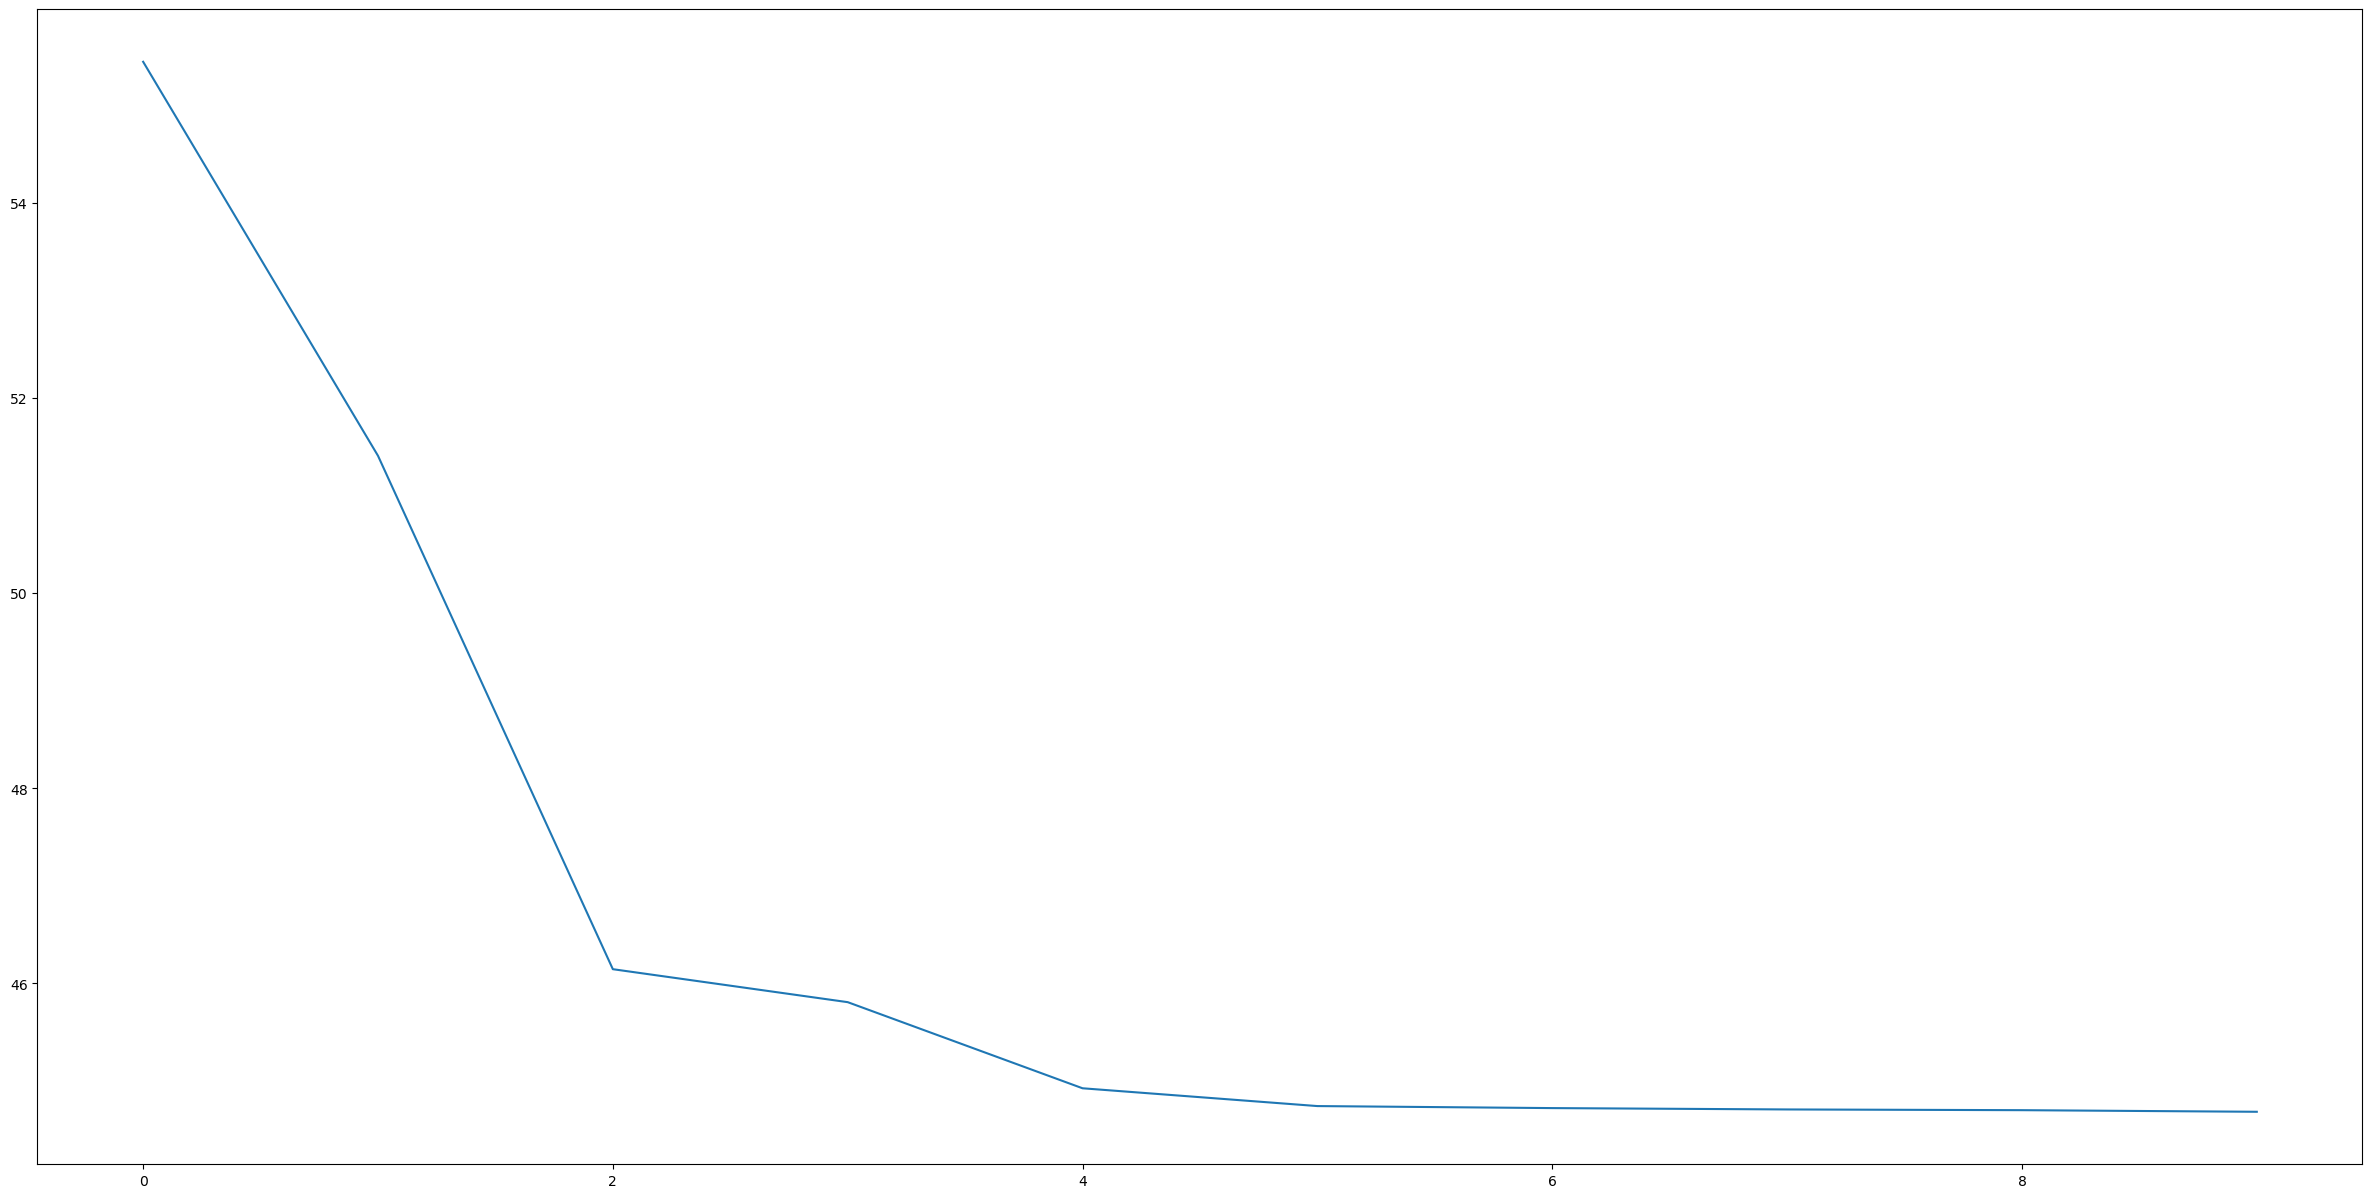

In [24]:
display(history.history)
plt.plot(history.history["loss"])
plt.show()

array([5.8426156, 7.833393 , 2.2555118, ..., 4.951509 , 4.951783 ,
       6.6911154], dtype=float32)

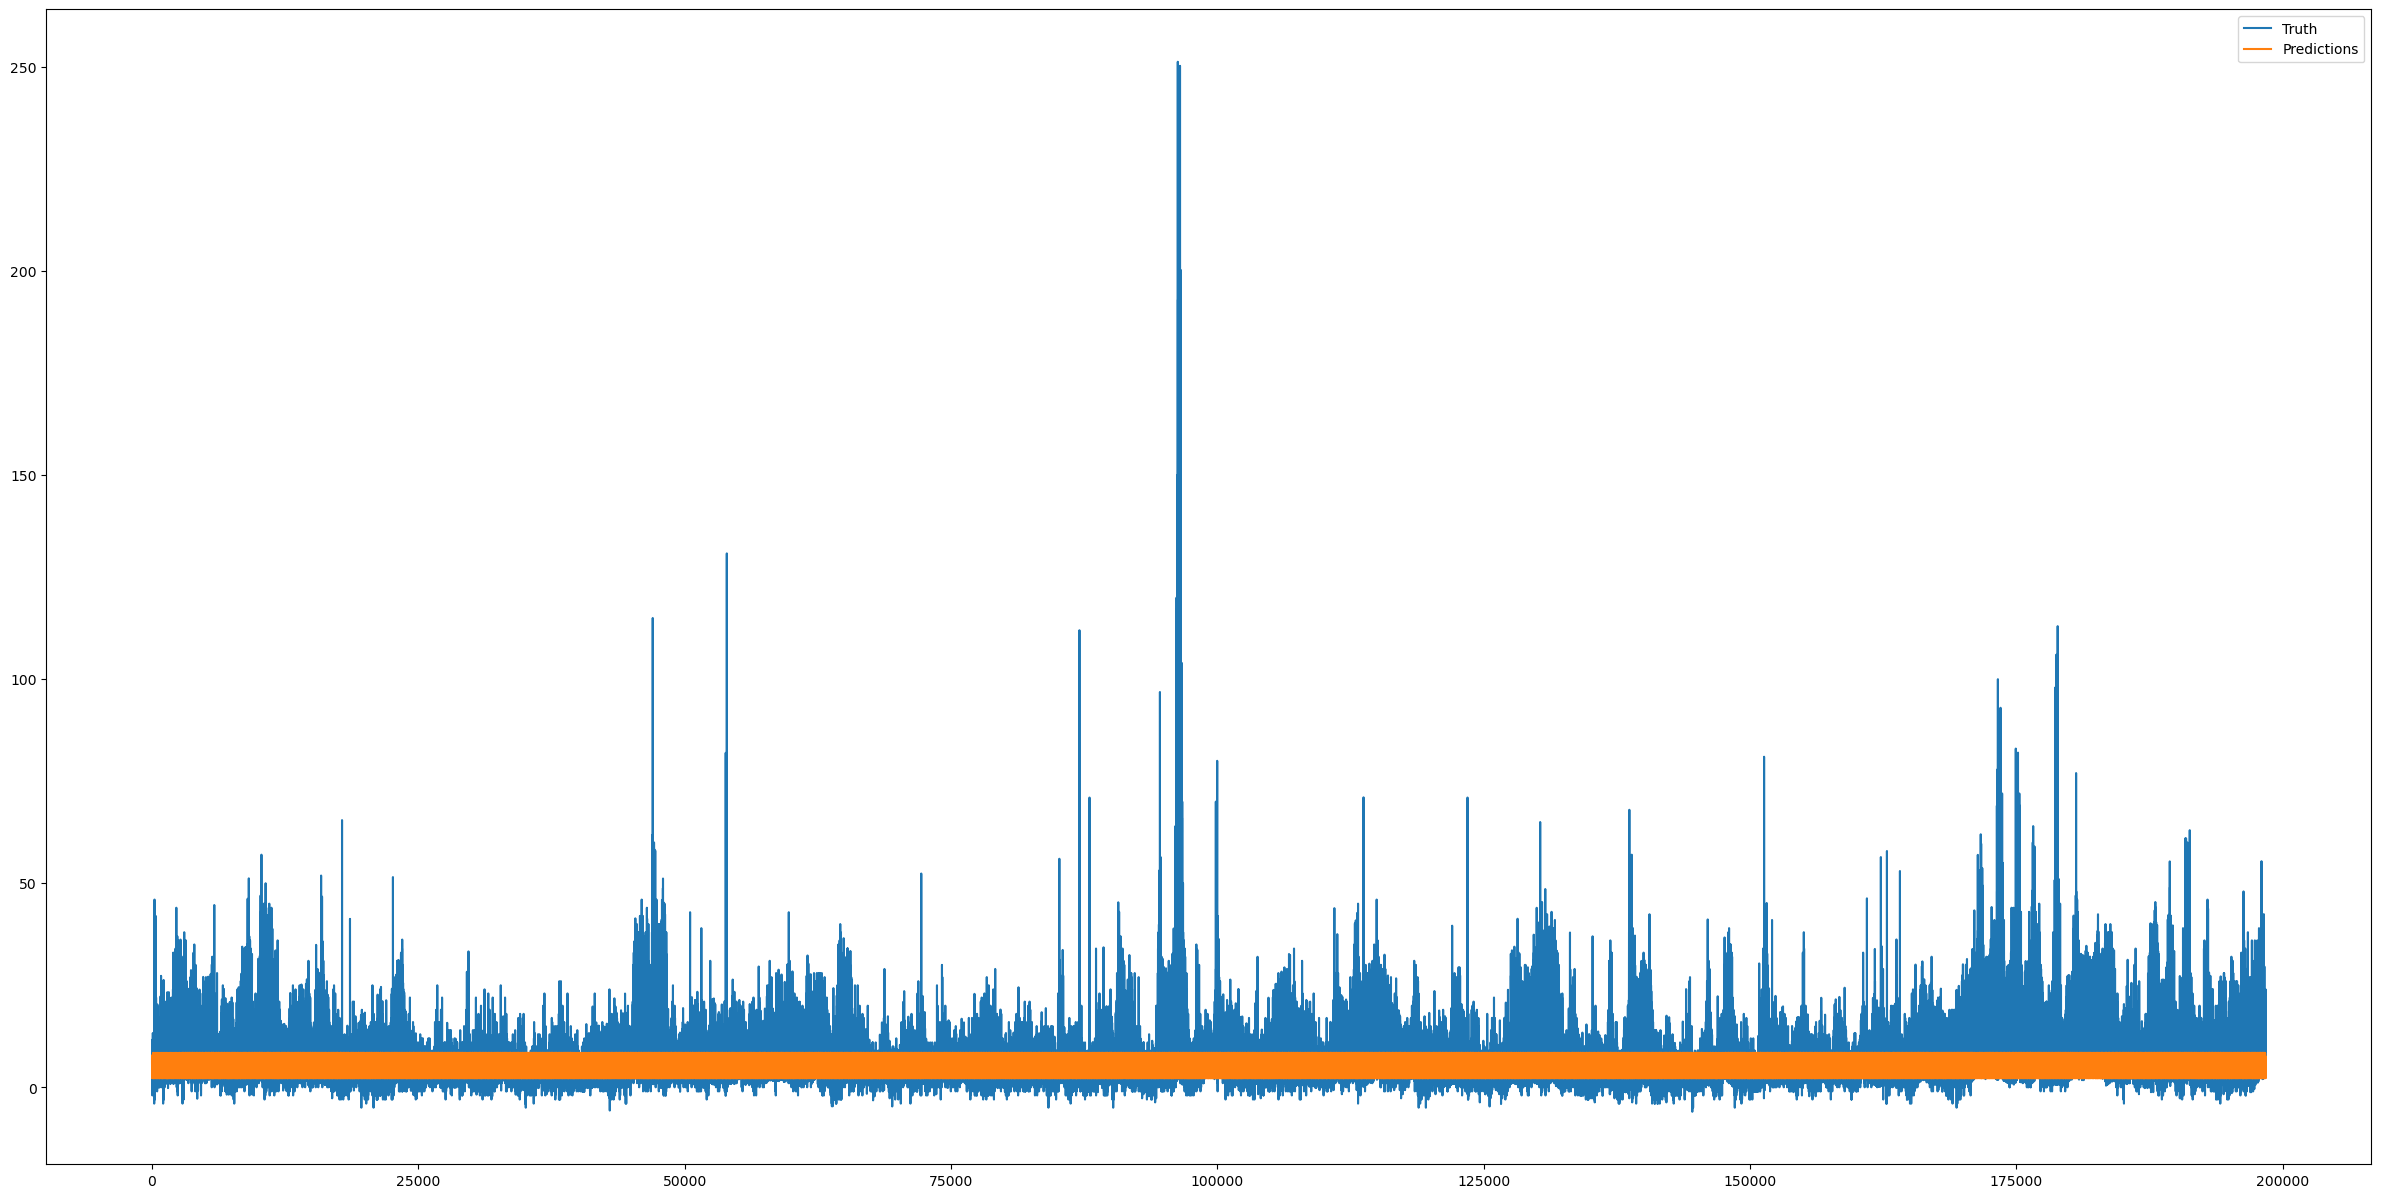

In [25]:
predictions = model.predict(test_features).flatten()
display(predictions)
plt.plot(test_labels.reset_index(drop=True), label="Truth")
plt.plot(predictions, label="Predictions")
plt.legend()

In [26]:
#drive.mount("/content/gdrive")
model.save("/content/comp3000model")
zip_location = make_archive("model", "zip", "/content/comp3000model")
#move(zip_location, "/content/gdrive/MyDrive/comp3000model/model.zip")
#drive.flush_and_unmount()

INFO:tensorflow:Assets written to: /content/comp3000model\assets
